In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
from __future__ import annotations
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import IPython.display
from matplotlib.colors import LinearSegmentedColormap
from typing import List, Tuple, Union

import candle
import candle.functions as F
from candle import Tensor, Parameter, Module, randn

# μParameterization / μTransfer experiments

Intuition:
- Under μParameterization, networks of increasing width **converge** to a limit they call the **feature-learning limit** for all training steps (different from the NKT "lazy" limit, which does not really describe modern practical networks)
- Therefore, given sufficiently large width, since convergence implies the functional and training dynamics are independent of the width, then the **optimal hyperparameters are also independent of the width**, which allows for hyperparameter transfer from small to large models.

Why does it converge? μParameterization was designed with the following goals [3]:
> 1. Every (pre)activation vector in a network should have Θ(1)-sized coordinates  
> 2. Network output should be O(1).  
> 3. All parameters should be updated as much as possible (in terms of scaling in width) without leading to divergence
   
The mechanical details of μP achieves these goals are explained in Appendix C [2] and Appendix J [1].

> References:  
> [1] [Tensor Programs V: Tuning Large Neural Networks via Zero-Shot Hyperparameter Transfer](https://arxiv.org/pdf/2203.03466.pdf), Yang et al. 2022  
> [2] [Feature Learning in Infinite-Width Neural Networks](https://arxiv.org/abs/2011.14522) Yang and Hu, 2020  
> [3] https://github.com/microsoft/mup/tree/main  
> [4] https://www.microsoft.com/en-us/research/blog/%C2%B5transfer-a-technique-for-hyperparameter-tuning-of-enormous-neural-networks/

## (0) Contents

* [(1) Define abc-parameterized model](#(1)-Define-abc-parameterized-model)
* [(2) Define Standard Parameterization (SP), Maximal Update Parameterizations (μP)](#(2)-Define-Standard-Parameterization-(SP),-Maximal-Update-Parameterizations-(μP))
* [(3) μTransfer: small and large models share optimal hyperparameters](#(3)-μTransfer:-small-and-large-models-share-optimal-hyperparameters)
* [(4) Coordinate Checks: for all training steps, activation coordinate norm does not depend on width](#(4)-Coordinate-Checks:-for-all-training-steps,-activation-coordinate-norm-does-not-depend-on-width) 

## (1) Define abc-parameterized model

In [3]:
class ABCLinear(Module):
    """abc-parameterized linear layer (see [2])."""

    def __init__(self,
                 d_input: int,
                 d_output: int,
                 a: float,
                 b: float,
                 width: int = None):
        super().__init__()
        self.d_input = d_input
        self.d_output = d_output
        self.a = a
        self.b = b
        if width is None:
            width = d_input
        self.width = width

        self.weight = Parameter(randn(d_input, d_output, std=width**(-b)))


    def forward(self, x):
        """
        Args:
            x: shape (batch, d_input)

        Returns:
            x: shape (batch, d_output)

        """
        return x @ self.weight * self.width**(-self.a)        


class ABCModel(Module):
    """abc-parameterized L-layer MLP."""

    def __init__(self,
                 width: int,
                 n_layers: int,
                 d_input: int,
                 d_output: int,
                 abc_parameterization: Callable):
        """
        Args:
            width, n_layers, d_input, d_output: dimensions of model
            abc_parameterization: function with signature
                def abc_parameterization(layer_index: int, n_layers: int) -> (a: int, b: int)
        
        """
        super().__init__()

        self.width = width
        self.d_input = d_input
        self.d_output = d_output

        (a, b) = abc_parameterization(0, n_layers)
        layers = [ABCLinear(d_input, width, a, b, width)]

        for l in range(1, n_layers):
            (a, b) = abc_parameterization(l, n_layers)
            layers.append(ABCLinear(width, width, a, b, width))

        (a, b) = abc_parameterization(n_layers, n_layers)

        self.layers = candle.ParameterList(layers)
        
        self.output = ABCLinear(width, d_output, a, b, width)


    def forward(self, x):
        """
        Args:
            x: shape (batch, d_input)

        Returns:
            x: shape (batch, d_output)

        """
        for layer in self.layers:
            x = layer(x)
            x = F.relu(x)

        return self.output(x)

## (2) Define Standard Parameterization (SP), Maximal Update Parameterizations (μP)

In [4]:
def sp_parameterization(layer_index: int, n_layers: int):
    """Standard parameterization."""
    a = 0
    if layer_index == 0:
        b = 0
    else:
        b = 1/2
        
    return (a, b)
    

def mu_parameterization(layer_index: int, n_layers: int):
    """Maximal update parameterization."""
    if layer_index == 0:
        a = -1/2
    elif layer_index == n_layers:
        a = 1/2
    else:
        a = 0
    b = 1/2
    
    return (a, b)

## (3) μTransfer: small and large models share optimal hyperparameters

> Under μP, different widths share the same optimal hyperparameters; under SP, they do not.

In [5]:
# Load MNIST data

from sklearn.datasets import load_digits

digits = load_digits()

X = Tensor(digits['data'] / 8 - 1)
y = Tensor(digits['target']).astype(int)

n_input = X.shape[1]
n_classes = len(set(y.data))

In [6]:
def optimal_learning_rate_search(
    abc_parameterization: Callable,
    title: str,
    width_grid: List[int] = [64, 128, 256, 512, 1024],
    learning_rate_grid: List[float] = np.power(10, np.linspace(-4, -0.5, 50)),
    trials: int = 20,
    epochs: int = 10,
    n_layers: int = 2,
):
    """Does a grid search on the optimal learning rate."""
    loss_by_width_lr = pd.DataFrame()
    
    for width in width_grid:
        for trial in range(trials):
            for lr in learning_rate_grid:
                model = ABCModel(width, n_layers, n_input, n_classes, abc_parameterization)
                optimizer = candle.optimizer.SGD(model.parameters(), learning_rate=lr)
    
                for epoch in range(epochs):
                    model.zero_grad()
    
                    output = model(X)
                    loss = F.cross_entropy_loss(output, y)
                    loss.backward()
                    
                    optimizer.step()
    
                result = pd.Series({'lr': lr,
                                    'width': width,
                                    'trial': trial,
                                    'loss': float(loss.data)})
                
                loss_by_width_lr = pd.concat([loss_by_width_lr, result], axis=1)
                
    loss_by_width_lr = loss_by_width_lr.T
    
    # PLot experiment results
    
    fig = plt.figure(figsize=(10, 7))
    cmap = LinearSegmentedColormap.from_list('blue_to_grey', ['blue', 'grey'])
    colors = cmap(np.linspace(1, 0, len(width_grid)))
    
    for (i, width) in enumerate(width_grid):
        loss_over_trials = loss_by_width_lr[loss_by_width_lr['width'] == width].groupby('lr')['loss']
        median = loss_over_trials.median()
        std = loss_over_trials.std()
    
        median.plot(color=colors[i], linewidth=1.3, alpha=0.7, label=width)
        plt.fill_between(median.index, median - std, median + std, color=colors[i], alpha=0.075)
    
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Training Loss')
    plt.legend(title='width', loc=2)
    plt.ylim(top=loss_by_width_lr['loss'].quantile(0.8) * 1.5, bottom=-0.2)
    plt.title(title)
    plt.grid()
    plt.tight_layout()
    plt.show()

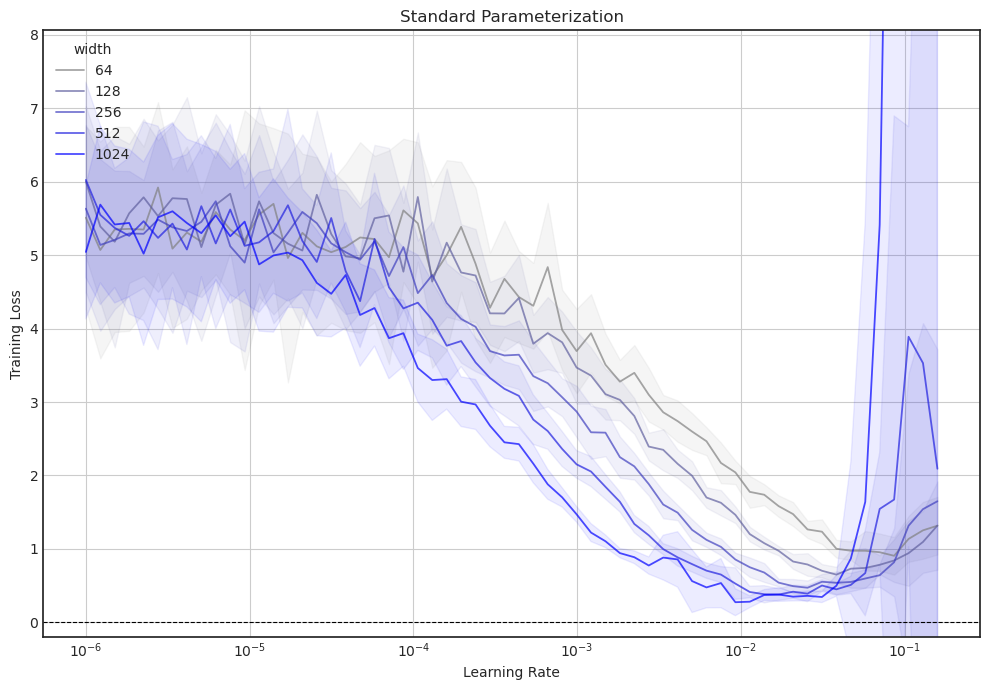

In [7]:
# Under standard parameterization, different widths do not share optimal learning rate

optimal_learning_rate_search(sp_parameterization,
                             title='Standard Parameterization',
                             width_grid=[64, 128, 256, 512, 1024],
                             learning_rate_grid=np.power(10, np.linspace(-6, -0.8, 60)))

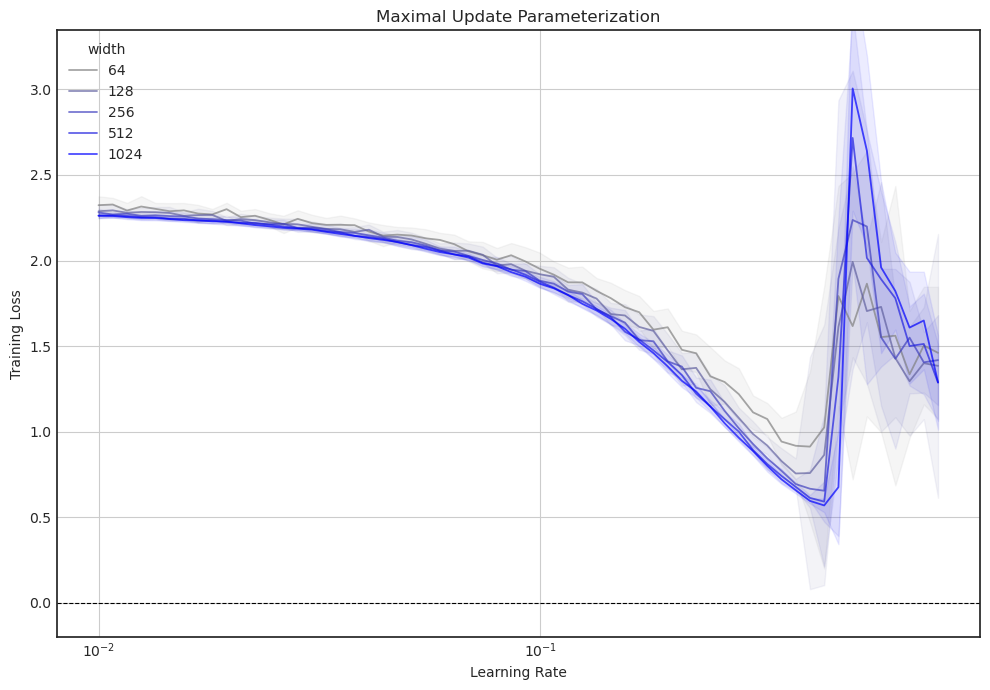

In [8]:
# Under μParameterization, different widths do share optimal learning rate

optimal_learning_rate_search(mu_parameterization,
                             title='Maximal Update Parameterization',
                             width_grid=[64, 128, 256, 512, 1024],
                             learning_rate_grid=np.power(10, np.linspace(-2, -0.1, 60)))

## (4) Coordinate Checks: for all training steps, activation coordinate norm does not depend on width

> Todo